# Modelos de regresión (reentrega)

El fin de este notebook es usar las ideas de `eda-reentrega.ipynb` para diseñar un modelo de regresión que nos permita explicar las características de la expectativa de vida.

Como primer paso vamos a importar las bibliotecas a utilizar y definir algunas funciones que nos van a ser de ayuda:

In [1]:
!make -C .. metnum.so
!cp ../metnum.so metnum.so

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from metnum import least_squares
from IPython.display import display, Markdown

make: se entra en el directorio '/home/iglosiggio/facu/metodos/labos/tp3'
make: 'metnum.so' está actualizado.
make: se sale del directorio '/home/iglosiggio/facu/metodos/labos/tp3'


In [2]:
def start_print_capture():
    global print
    real_print = print
    captured = ''
    
    def fake_print(v):
        nonlocal captured
        captured += v + '\n'

    print = fake_print

    def stop_capture():
        global print
        print = real_print
        display(Markdown(captured))

    return stop_capture

def normalizar(M):
    return (M - np.mean(M)) / np.std(M)

def TSS(B):
    return np.sum((B - np.mean(B))**2)

def RSS(A, X, B):
    return np.sum((B - A @ X)**2)

def R2(RSS, TSS):
    return (TSS - RSS) / TSS

def R2_ajustado(R2, N, p):
    return 1 - (1 - R2)*(N - 1)/(N - p - 1)

def leverage(X):
    X = np.array(X)
    return np.diag(X @ np.linalg.inv((X.T @ X)) @ X.T)

def residual_plot(A, X, B):
    leverage_score = leverage(A)
    predicted = A @ X
    residual = B - predicted
    plt.scatter(predicted, residual, s=9, c=leverage_score)
    plt.xlabel("Predicciones")
    plt.ylabel("Residuos")
    plt.hlines(0, xmin=min(predicted), xmax=max(predicted))
    plt.colorbar()
    plt.title("Residual plot")
    return plt

def probar_modelo(param_A):
    display_markdown = start_print_capture()
    A = param_A.copy()
    print('### Resultados')
    print(f'Se evaluó un modelo con {len(A.columns)} features (más el término constante)')
    # Normalizamos A
    A = normalizar(A)
    # Agregamos una columna para el término constante
    A['k'] = 1
    B = df['Life expectancy']
    N = len(A)
    p = len(A.columns)
    X = least_squares(A, B)
    tss = TSS(B)
    rss = RSS(A, X, B)
    r2 = R2(rss, tss)
    r2_ajustado = R2_ajustado(r2, N, p)
    leverage_score = leverage(A)
    mean_leverage = leverage_score.mean()
    print('#### Métricas')
    print(f'- **TSS:** {tss}')
    print(f'- **RSS:** {rss}')
    print(f'- **R^2:** {r2}')
    print(f'- **R^2 ajustado:** {r2_ajustado}')
    print(f'- **Mean leverage:** {mean_leverage}')
    print(f'- **Maybe outliers:**')
    print(f'  * Rows with leverage over two times the mean: {sum(1 for row_leverage in leverage_score if row_leverage > 2 * mean_leverage)}')
    print(f'  * Rows with leverage over three times the mean: {sum(1 for row_leverage in leverage_score if row_leverage > 3 * mean_leverage)}')
    print('#### Coeficientes de X')
    for (col, coeff) in zip(A.columns, X):
        print(f'- **{col}:** _{coeff}_')
    vif(param_A)
    plt = residual_plot(A, X, B)
    plt.show()
    display_markdown()
    #return A, X, B

def vif(M):
    columns = list(M.columns)
    # Normalizamos todo
    #M = normalizar(M)
    print('#### VIF')
    for column in columns:
        A = M[[col for col in M.columns if col != column]]
        B = M[column]
        X = least_squares(A, B)
        tss = TSS(B)
        rss = RSS(A, X, B)
        r2 = R2(rss, tss)
        print(f'- **{column}**: {1/(1 - r2)}')

df = pd.read_csv('../data/dataset-completado.csv')
df.columns


def cook(param_A):
    A = param_A.copy()
    A = normalizar(A)
    A['k'] = 1
    results = np.zeros(len(A))
    B = df['Life expectancy']
    
    X = least_squares(A, B)
    predicted = A @ X
    residual = B - predicted
    mean_squared_error = (residual.T @ residual) / (len(A) - len(A.columns))
    for i in range(len(A)):
        A_without_i = pd.concat([A.iloc[0:i], A.iloc[i+1:len(A)]])
        B_without_i = pd.concat([B.iloc[0:i], B.iloc[i+1:len(B)]])
        originally_predicted_without_i = np.concatenate(X[0:i], X[i+1:len(X)])
        X = least_squares(A_without_i, B)
        predicted_without_i = A_without_i @ X
        residual_without_i = B - predicted_without_i
        display(sum((originally_predicted_without_i - predicted_without_i)**2))
        results[i] = sum((predicted - predicted_without_i)**2) / (len(A.columns)*mean_squared_error)
    return results
#cook(df[['Alcohol', 'infant deaths']])

Con esto ahora podemos empezar a evaluar distintos modelos, carguemos los datos e intentemos algo muy tonto:

## Primer modelo: Usar sólo las variables categóricas

Como primer modelo (ultra simplista) consideramos usar sólo las variables categóricas. Suponemos de primera mano que este es un modelo _"malo"_ pero sencillo, un problema interesante es el de  modelar el feature de regiones (es decir, traducir al nombre de la región por un número). Para esto decidimos numerarlos en orden creciente de la región con menor expectativa de vida promedio a la de mayor expectativa de vida promedio.

,Life expectancy
Region,
Africa,57.417952
South-East Asia,68.644318
Eastern Mediterranean,69.800893
Western Pacific,72.195833
Americas,73.485417
Europe,76.149625


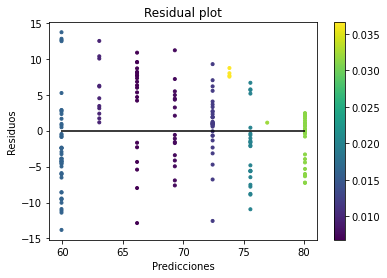

### Resultados
Se evaluó un modelo con 2 features (más el término constante)
#### Métricas
- **TSS:** 15359.076092896175
- **RSS:** 6105.6620202170925
- **R^2:** 0.6024720508389785
- **R^2 ajustado:** 0.5958095712441009
- **Mean leverage:** 0.016393442622950845
- **Maybe outliers:**
  * Rows with leverage over two times the mean: 4
  * Rows with leverage over three times the mean: 0
#### Coeficientes de X
- **int_status:** _1.7161788157270943_
- **int_region:** _6.144295219189531_
- **k:** _69.22493169398908_
#### VIF
- **int_status**: 1.218640164988835
- **int_region**: 0.32207653230236316


In [3]:
avg_life_expectancy_per_region = df.groupby('Region')[['Region', 'Life expectancy']].mean().sort_values(by='Life expectancy')
display(avg_life_expectancy_per_region)
region_int_mapping = {
    region: idx + 1
    for idx, region
    in enumerate(avg_life_expectancy_per_region.reset_index().Region)
}
df['int_status'] = df['Status'].apply(lambda x: 0 if x=='Developing' else 1)
df['int_region'] = df['Region'].apply(lambda x: region_int_mapping[x])
probar_modelo(df[['int_status', 'int_region']])

Como era de esperarse el residualplot no está muy bueno...

Dado que para una combinación `(Región, Estado)` sólo obtenemos un resultado observamos estas líneas verticales que representan cada una de las combinaciones. Es interesante notar que pese a tener seis regiones y dos estados sólo se observan nueve rectas verticales, es decir: hay regiones sin países desarrollados.

Para varias de las rectas vemos dos grupos distinguidos. Conjeturamos que estos nos podría dar pié para justificar una clasificación intermedia entre "país desarrollado" y "país en vías de desarrollo", pero no ahondaremos mucho más en esto.

Sobre los resultados observadostenemos algo de poder predictivo y podemos notar un par de cosas sobre los coeficientes de X:
* La región del país tiene casi tres veces el peso del estado del mismo.
* Nuestra predicción más baja es de entre 59 y 60 años.

## Agregando variables no categóricas: Acceso al agua potable

Cómo vimos en el análisis exploratorio de datos la proporción de gente con acceso a agua potable mantiene una alta correlación con la expectativa de vida. Es por esto que es una de las primeras variables que queremos considerar.

Vale la pena apreciar que considerar Adult Mortality (la variable de mayor correlación) sería tonto si buscáramos que el modelo nos permita explicar las predicciones, dado que "cuándo mucha gente se muere antes de los 60 años entonces baja la expectativa de vida del país" no es información relevante. Esta misma crítica se podría hacer respecto de `int_status` e `int_region`: Para la primer variable "dejar de ser un país desarrollado" no nos da mucha información, para la segunda entendemos que mover un país de una región a otra resulta poco práctico. Nuestro fin al utilizar estas variables es tenerlas en mente para futuras interaction variables. Creemos que los principales factores que afectan a las regiones más carenciadas no afectan tanto a las de mayor expectativa de vida.

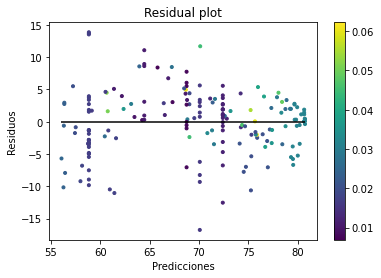

### Resultados
Se evaluó un modelo con 3 features (más el término constante)
#### Métricas
- **TSS:** 15359.076092896175
- **RSS:** 4416.369490668198
- **R^2:** 0.712458648947586
- **R^2 ajustado:** 0.7059970455531498
- **Mean leverage:** 0.02185792349726782
- **Maybe outliers:**
  * Rows with leverage over two times the mean: 11
  * Rows with leverage over three times the mean: 0
#### Coeficientes de X
- **int_status:** _0.5244646208732608_
- **int_region:** _2.2831451865420087_
- **Population using safely managed drinking-water services (%):** _5.464945582357517_
- **k:** _69.22493169398908_
#### VIF
- **int_status**: 1.2860256518972517
- **int_region**: 2.7459872164284636
- **Population using safely managed drinking-water services (%)**: 2.713998982971346


In [4]:
probar_modelo(df[['int_status', 'int_region', 'Population using safely managed drinking-water services (%)']])

Vemos entonces un aumento importante en la varianza explicada por este nuevo modelo. A éste se le suma un aumento a la multicolinearidad (esperable dado que el acceso al agua potable es un problema endémico en ciertas regiones y en estas regiones no hay muchos países desarrollados).

### Expandiendo el modelo

Viendo los coeficientes de $X$ decidimos reemplazar el estado del país por otra variable que aporte más información al meodelo. Elegimos la cantidad estimada de muertes por accidentes de tránsito.

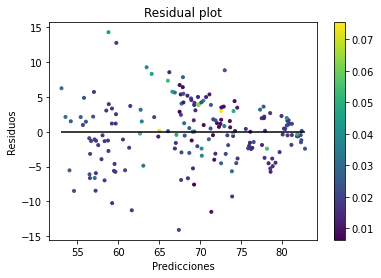

### Resultados
Se evaluó un modelo con 3 features (más el término constante)
#### Métricas
- **TSS:** 15359.076092896175
- **RSS:** 3457.5232064344373
- **R^2:** 0.7748872923395699
- **R^2 ajustado:** 0.7698285798078748
- **Mean leverage:** 0.021857923497267805
- **Maybe outliers:**
  * Rows with leverage over two times the mean: 13
  * Rows with leverage over three times the mean: 2
#### Coeficientes de X
- **int_region:** _0.4932027005610582_
- **Population using safely managed drinking-water services (%):** _5.254763802679524_
- **Estimated road traffic death rate:** _-3.220332118175236_
- **k:** _69.22493169398908_
#### VIF
- **int_region**: 2.744481160161956
- **Population using safely managed drinking-water services (%)**: 2.7541979098486666
- **Estimated road traffic death rate**: 0.3335428923010592


In [5]:
probar_modelo(df[['int_region', 'Population using safely managed drinking-water services (%)', 'Estimated road traffic death rate']])

El $R^2$ del modelo aumentó a 0.77. La nueva variable tiene un coeficiente en el mismo orden que el % de gente con acceso a agua potable.

Visto el nuevo coeficiente de nuestra codificación de región decidimos cambiarla por una variable con más datos. Elegimos la cantidad de muertes infantiles a causa del SIDA. Esta es una variable interesante dado que sólo registra valores en países no desarrollados.

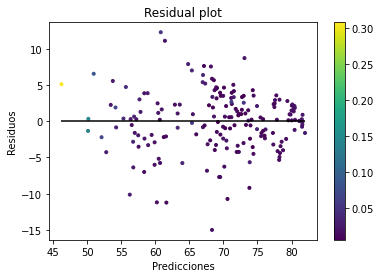

### Resultados
Se evaluó un modelo con 3 features (más el término constante)
#### Métricas
- **TSS:** 15359.076092896175
- **RSS:** 3042.6466279121523
- **R^2:** 0.8018991110201331
- **R^2 ajustado:** 0.797447405649799
- **Mean leverage:** 0.02185792349726778
- **Maybe outliers:**
  * Rows with leverage over two times the mean: 11
  * Rows with leverage over three times the mean: 6
#### Coeficientes de X
- **Population using safely managed drinking-water services (%):** _5.0937356424945825_
- **Estimated road traffic death rate:** _-2.827134424737599_
- **HIV/AIDS:** _-1.7780299161977688_
- **k:** _69.22493169398908_
#### VIF
- **Population using safely managed drinking-water services (%)**: 0.46017421520919366
- **Estimated road traffic death rate**: 0.509670179567399
- **HIV/AIDS**: 1.3486587872865536


In [6]:
probar_modelo(df[['Population using safely managed drinking-water services (%)', 'Estimated road traffic death rate', 'HIV/AIDS']])

Cómo esperábamos la variable nueva tiene un coeficiente negativo. El incremento de $R^2$ es bastante pequeño pero creemos que es un modelo prometedor. Vamos a adicionar una última variable: la cantidad de años de escolaridad de cada país.

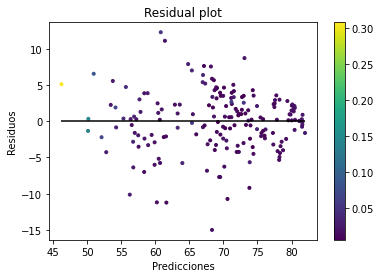

### Resultados
Se evaluó un modelo con 3 features (más el término constante)
#### Métricas
- **TSS:** 15359.076092896175
- **RSS:** 3042.6466279121523
- **R^2:** 0.8018991110201331
- **R^2 ajustado:** 0.797447405649799
- **Mean leverage:** 0.02185792349726778
- **Maybe outliers:**
  * Rows with leverage over two times the mean: 11
  * Rows with leverage over three times the mean: 6
#### Coeficientes de X
- **Population using safely managed drinking-water services (%):** _5.0937356424945825_
- **Estimated road traffic death rate:** _-2.827134424737599_
- **HIV/AIDS:** _-1.7780299161977688_
- **k:** _69.22493169398908_
#### VIF
- **Population using safely managed drinking-water services (%)**: 0.46017421520919366
- **Estimated road traffic death rate**: 0.509670179567399
- **HIV/AIDS**: 1.3486587872865536


In [7]:
probar_modelo(df[['Population using safely managed drinking-water services (%)', 'Estimated road traffic death rate', 'HIV/AIDS']])

Notamos un gran aumento del R2 sumado a esto los residuos están casi todos entre 5 y -5. ¡Un montón de progreso!